In [1]:
from alpha_vantage.timeseries import TimeSeries

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from scipy.stats import shapiro, jarque_bera
from statsmodels.tsa.stattools import adfuller

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense 
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Attention 

from plotly.subplots import make_subplots
import plotly.graph_objs as go

from tqdm import tqdm
import pickle 

In [ ]:
# Original code from: https://colab.research.google.com/drive/18WiSw1K0BW3jOKO56vxn11Fo9IyOuRjh#scrollTo=2SoQJk5BYOas
# We use it as a base for our implementation

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = pd.read_csv('NVDA.csv')

In [4]:
# load data
train = np.load('./Train/train_close.npy')

X_train = np.load('./Train/X_train.npy')
y_train = np.load('./Train/y_train.npy')
X_train_date = np.load('./Train/X_train_date.npy')

X_val = np.load('./Validation/X_val.npy')
val = np.load('./Validation/val.npy')

X_test = np.load('./Test/X_test.npy')
# X_test_date = np.load('./Test/X_test_date.npy')
test = np.load('./Test/test_close.npy')

# load the sc
sc_val = pickle.load(open('./Scaler/scaler_val.pkl', 'rb'))
sc_test = pickle.load(open('./Scaler/scaler_test.pkl', 'rb'))

In [5]:
def LSTM_nvidia(X_train):
    model = Sequential()
    model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.3))
    model.add(LSTM(units=200, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=200, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=200))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = LSTM_nvidia(X_train)
model.fit(X_train, y_train, epochs=300, batch_size=len(X_train), verbose=1)

2024-03-31 23:38:01.127280: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-03-31 23:38:01.127301: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-03-31 23:38:01.127305: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-03-31 23:38:01.127337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-31 23:38:01.127350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/300


2024-03-31 23:38:02.742170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.1702
Epoch 2/300
1/1 [==============================] - 0s 28ms/step - loss: 0.1506
Epoch 3/300
1/1 [==============================] - 0s 25ms/step - loss: 0.1285
Epoch 4/300
1/1 [==============================] - 0s 23ms/step - loss: 0.0993
Epoch 5/300
1/1 [==============================] - 0s 23ms/step - loss: 0.0646
Epoch 6/300
1/1 [==============================] - 0s 22ms/step - loss: 0.0352
Epoch 7/300
1/1 [==============================] - 0s 21ms/step - loss: 0.0455
Epoch 8/300
1/1 [==============================] - 0s 21ms/step - loss: 0.0614
Epoch 9/300
1/1 [==============================] - 0s 21ms/step - loss: 0.0430
Epoch 10/300
1/1 [==============================] - 0s 20ms/step - loss: 0.0281
Epoch 11/300
1/1 [==============================] - 0s 22ms/step - loss: 0.0258
Epoch 12/300
1/1 [==============================] - 0s 20ms/step - loss: 0.0293
Epoch 13/300
1/1 [==============================] - 0s 21ms/ste

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 dropout (Dropout)           (None, 5, 200)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 200)            320800    
                                                                 
 dropout_1 (Dropout)         (None, 5, 200)            0         
                                                                 
 lstm_2 (LSTM)               (None, 5, 200)            320800    
                                                                 
 dropout_2 (Dropout)         (None, 5, 200)            0         
                                                                 
 lstm_3 (LSTM)               (None, 200)               3

In [6]:
def prediction_LSTM(val, sc, model):
    predicted_stock_price = model.predict(val)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    return predicted_stock_price

In [7]:
predicted_stock_price_val = prediction_LSTM(X_val, sc_val, model)
predicted_stock_price_test = prediction_LSTM(X_test, sc_test, model)

8/8 [==============================] - 0s 6ms/step


In [8]:
# mse for validation
mse_val = np.mean(np.square(val - predicted_stock_price_val))
print('MSE for validation:', mse_val)
rmse_val = np.sqrt(mse_val)
print('RMSE for validation:', rmse_val)

# mse for test
mse_test = np.mean(np.square(test - predicted_stock_price_test))
print('MSE for test:', mse_test)
rmse_test = np.sqrt(mse_test)
print('RMSE for test:', rmse_test)

MSE for validation: 3005.3517531819944
RMSE for validation: 54.82108858078244
MSE for test: 50944.92441834474
RMSE for test: 225.70982348658362


In [9]:
data_for_validation = data.iloc[len(train):len(train)+len(val)]
data_for_validation.loc[:, 'Date'] = pd.to_datetime(data_for_validation['Date'])

In [10]:
data_for_test = data.iloc[len(train)+len(val):]
data_for_test.loc[:, 'Date'] = pd.to_datetime(data_for_test['Date'])

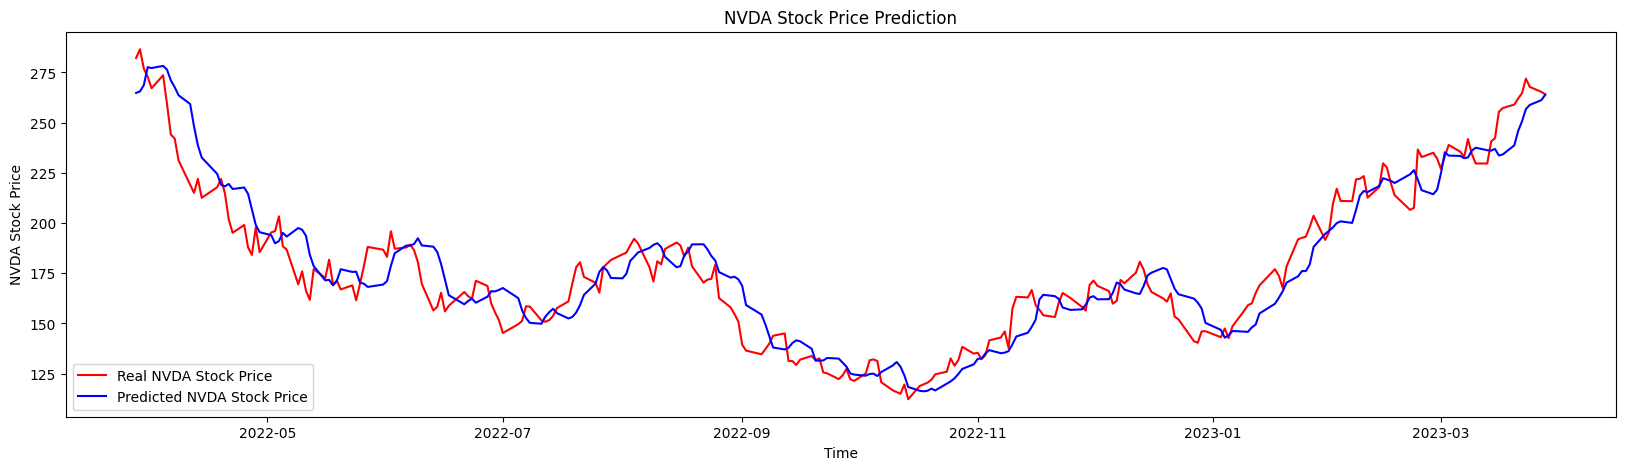

In [11]:
# plot the prediction for close price
plt.figure(figsize=(20, 5))
plt.plot(data_for_validation["Date"], val, color='red', label='Real NVDA Stock Price')
plt.plot(data_for_validation["Date"],predicted_stock_price_val, color='blue', label='Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()

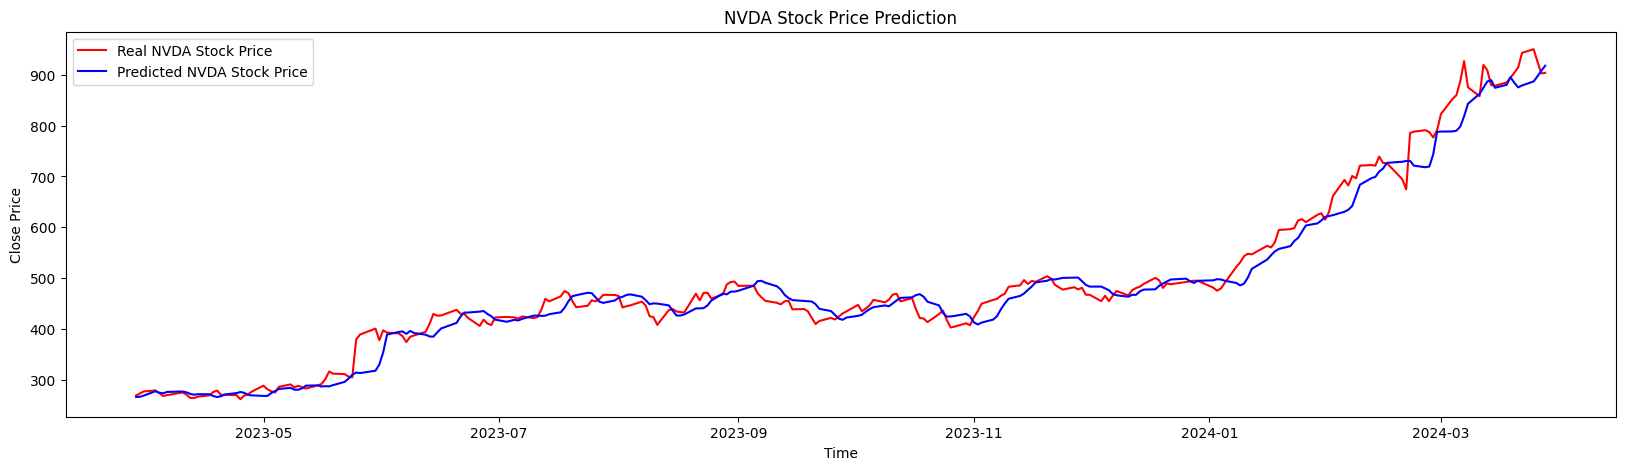

In [12]:
# plot the prediction for close price
plt.figure(figsize=(20, 5))
plt.plot(data_for_test["Date"], test, color='red', label='Real NVDA Stock Price')
plt.plot(data_for_test["Date"], predicted_stock_price_test, color='blue', label='Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [13]:
predicted_stock_price_val_df = pd.DataFrame(predicted_stock_price_val, columns=['Predicted'])
predicted_stock_price_test_df = pd.DataFrame(predicted_stock_price_test, columns=['Predicted'])

In [30]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=data_for_validation["Date"], y=predicted_stock_price_val_df["Predicted"], mode='lines', name='Predicted Close Price (Validation)'), row=1, col=1)
fig.add_trace(go.Scatter(x=data_for_validation["Date"], y=val, mode='lines', name='Close Price (Validation)'), row=1, col=1)

fig.add_trace(go.Scatter(x=data_for_test["Date"], y=test, mode='lines', name='Close Price (Test)'), row=2, col=1)
fig.add_trace(go.Scatter(x=data_for_test["Date"], y=predicted_stock_price_test_df["Predicted"], mode='lines', name='Predicted Close Price (Test)'), row=2, col=1)

fig.update_yaxes(title_text="Close Price ($)", row=1, col=1)
fig.update_yaxes(title_text="Close Price ($)", row=2, col=1)

fig.update_layout(height=600)

fig.show()

In [15]:
predicted_stock_price_test_df["Real"] = test
predicted_stock_price_test_df.index = data_for_test["Date"]
predicted_stock_price_test_df["Predicted"] = predicted_stock_price_test_df["Predicted"].shift(1)
predicted_stock_price_test_df.dropna(inplace=True)

/Users/vincentzhao/anaconda3/envs/deep_learning_finance/lib/python3.11/site-packages/pandas/core/indexes/base.py:7630: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



In [26]:
predicted_stock_price_test_df

,Predicted,Real
Date,,
2023-03-30,266.840057,273.829987
2023-03-31,267.255646,277.769989
2023-04-03,269.620575,279.649994
2023-04-04,278.111572,274.529999
2023-04-05,275.168335,268.809998
...,...,...
2024-03-22,875.047913,942.890015
2024-03-25,878.842590,950.020020
2024-03-26,886.682251,925.609985


In [25]:
predicted_stock_price_test_df.to_csv('LSTM_for_trading.csv')

In [16]:
whole_data = np.concatenate((val, test), axis=0)
whole_data_predicted = np.concatenate((predicted_stock_price_val, predicted_stock_price_test), axis=0)

In [17]:
total_len = len(whole_data_predicted)
target_data = data[len(train):total_len+len(train)]
target_data.loc[:, 'Date'] = pd.to_datetime(target_data['Date'])

In [18]:
whole_data_predicted = whole_data_predicted.reshape(-1)
whole_data_predicted = pd.array(data=whole_data_predicted)

In [19]:
final_data = pd.DataFrame( {'Date': target_data['Date'], 'Close': whole_data, 'Predicted_Close': whole_data_predicted})
final_data.set_index('Date', inplace=True)

/Users/vincentzhao/anaconda3/envs/deep_learning_finance/lib/python3.11/site-packages/pandas/core/indexes/base.py:7587: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



In [20]:
final_data["Predicted_Close"] = final_data["Predicted_Close"].shift(-1)
final_data.fillna(method='ffill', inplace=True)

/var/folders/20/0y46cgg97gs8kf_s9bthlzgm0000gn/T/ipykernel_48794/1423392921.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [21]:
final_data.to_csv('final_data_LSTM.csv')

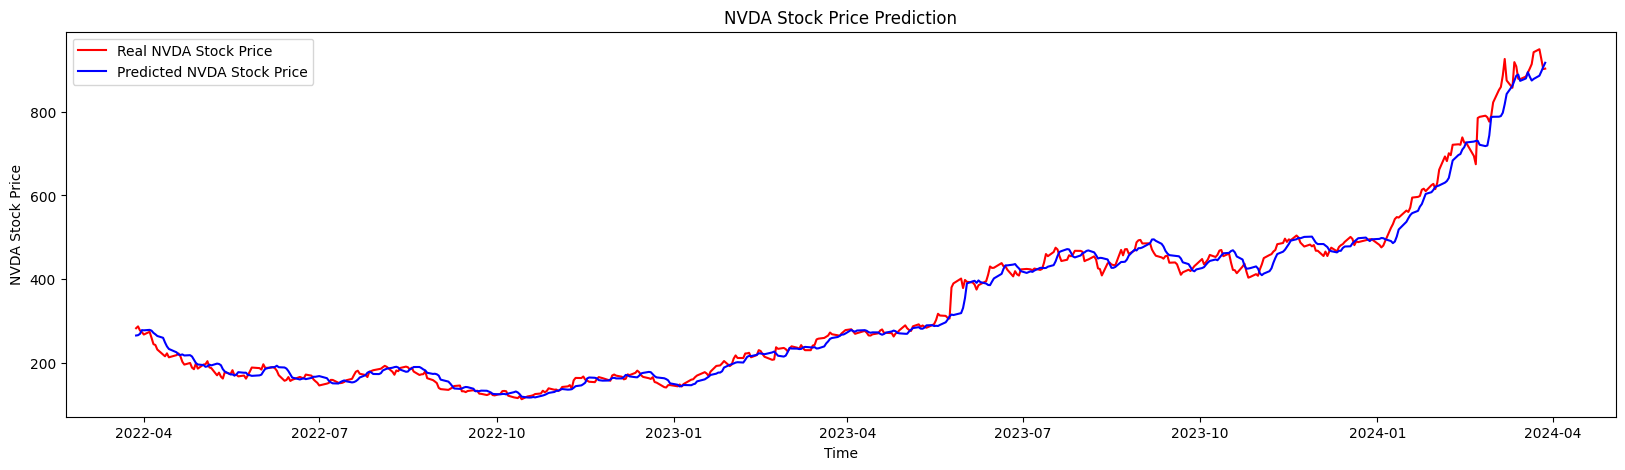

In [22]:
plt.figure(figsize=(20,5))
plt.plot(target_data["Date"], whole_data, color = 'red', label = 'Real NVDA Stock Price')
plt.plot(target_data["Date"], whole_data_predicted, color = 'blue', label = 'Predicted NVDA Stock Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()